# Notebook for ZFOURGE CDFS Luminosity (Magnitude) Functions Following the SDSS Example

### Import and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

n_lum_bins = 30 # number of luminosity bins
mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
all_mag_bins = [30, 25, 25, 20, 15, 10] # number of absolute magnitude bins in each redshift bin
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Luminosity Distributions

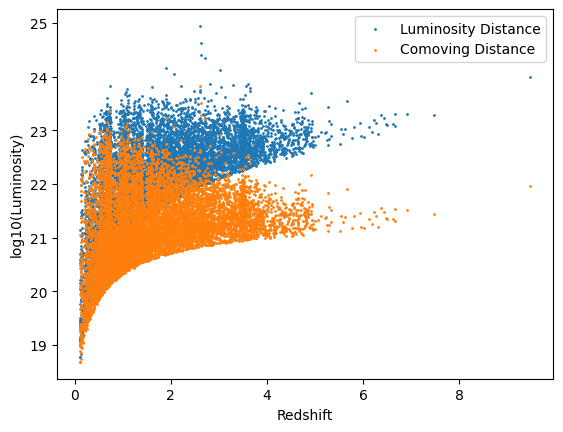

In [2]:
# Mask AB mag limit
mag_ab = 25 - 2.5*np.log10(df['FKs']) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)
fks = df['FKs'].values[mask] # apparent magnitude
z = df['zpk'].values[mask] # redshift
f = 0.3631 * fks * 10**-32  # uJy -> W/m^2/Hz

# Luminosity Distance
d = cosmo.luminosity_distance(z).to(u.m).value # meters
luminosity = 4 * np.pi * (d**2) * f # m^2 * W/m^2/Hz = W/Hz

# Comoving Distance
d_cm = cosmo.comoving_distance(z).to(u.m).value # meters
luminosity_cm = 4 * np.pi * (d_cm**2) * f # m^2 * W/m^2/Hz = W/Hz

plt.scatter(z, np.log10(luminosity), s=1, label='Luminosity Distance')
plt.scatter(z, np.log10(luminosity_cm), s=1, label='Comoving Distance')
plt.ylabel('log10(Luminosity)')
plt.xlabel('Redshift')
plt.legend()
plt.show()

### Luminosity-distance relationship

1) Calculate the luminosity of each galaxy given the parameters of: $D$ the luminosity distance in $m$ to the galaxy and the flux $F$ received from the galaxy in ${W}/{m^2}/Hz$ to get luminosity $L$ in $W/Hz$

$$
L = 4 \pi D^2 F
$$

2) Once the luminosity of each galaxy has been calculated, rearrange equation 1 to calculate the maximum distance. This equation uses the same luminosity $L$ as in equation 1) but with a new $F$: the flux limit of survey, $F_{lim}$. This effectively calculates the maximum possible distance of the galaxy given we know it's instrinsic luminosity but if it's flux were at the survey limit.

$$
D_{max} = \sqrt{\frac{L}{4 \pi F_{lim}}}
$$


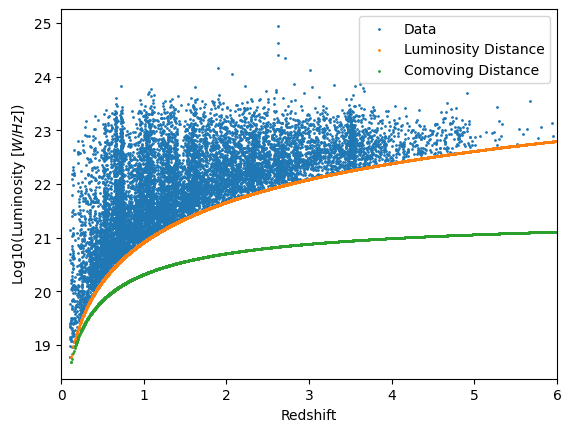

In [3]:
# Convert flux
f_lim = 10 ** ((mag_lim + 56.1) / -2.5) # AB mag -> W/m^2/Hz

# Maximum luminosity distance
dmaxs = np.sqrt(luminosity / (4*np.pi*f_lim)) # meters
dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc

# Maximum comoving distance
dmaxs_cm = np.sqrt(luminosity_cm / (4*np.pi*f_lim)) # meters
dmaxs_cm *= 3.241 * 10 ** -23 # meters -> Mpc
dmaxs_cm[dmaxs_cm > 10000] = 10000 # z~15

# Plot luminosity vs redshift
z_lim_cm = z_at_value(cosmo.comoving_distance, dmaxs_cm * u.Mpc)
z_lim = z_at_value(cosmo.luminosity_distance, dmaxs * u.Mpc)

plt.scatter(z, np.log10(luminosity), s=1, label='Data')
plt.scatter(z_lim, np.log10(luminosity), s=1, label='Luminosity Distance')
plt.scatter(z_lim_cm, np.log10(luminosity_cm), s=1, label='Comoving Distance')
plt.xlabel('Redshift')
plt.ylabel('Log10(Luminosity [$W/Hz$])')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.legend()
plt.show()

### Luminosity Bin Limits vs Maximum Redshift

This shows that when calculating the maximum possible distance, to eventually calculate volume, the luminosities no longer follow the `luminosity_distance` limit and instead follow the `comoving_distance` limit. This must be corrected by excluding sources blow the `luminosity_distance` limit.

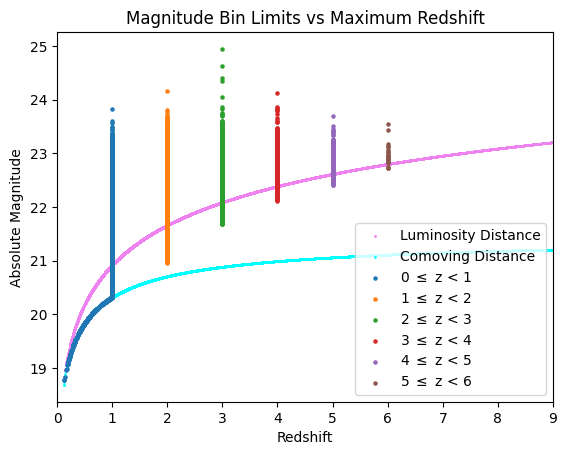

In [4]:
plt.scatter(z_lim, np.log10(luminosity), s=1, label='Luminosity Distance', color='violet')
plt.scatter(z_lim_cm, np.log10(luminosity_cm), s=1, label='Comoving Distance', color='cyan')
for (z_min, z_max), n_lum_bins in zip(redshift_bins, all_mag_bins):
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*f_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    lum_bin = lum_bin[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Find the redshift at the maximum distance
    z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Magnitude Bin Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend(loc='lower right')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.show()

### Calculate and save binned counts, volumes, magnitudes, & data

Correcting for the above

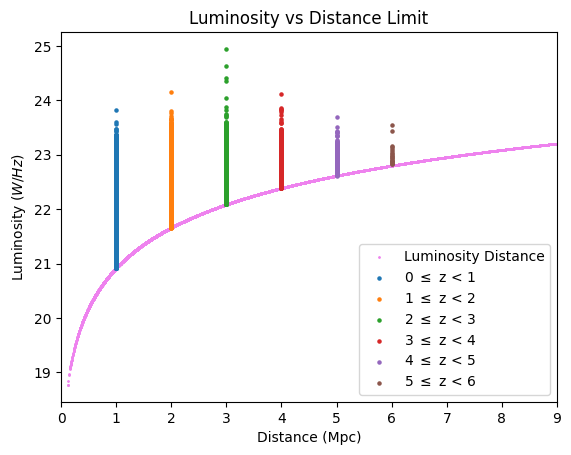

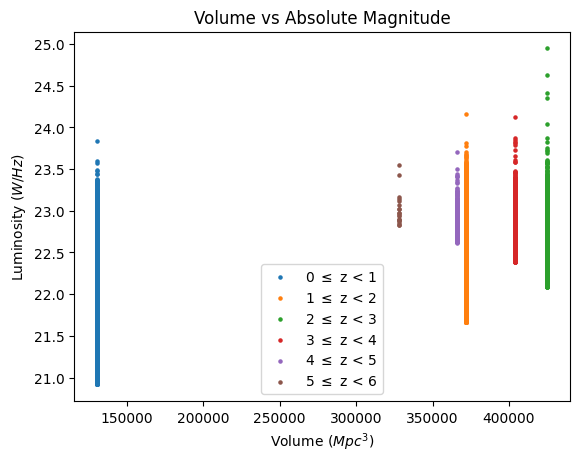

In [5]:
def lum_lim(z):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # m^2 * W/m^2/Hz = W/Hz 

all_data = []

plt.scatter(z_lim, np.log10(luminosity), s=1, label='Luminosity Distance', color='violet')
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*f_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Lumiosity bins must be less than or equal to the maximum absolute magnitude (from luminosity distance)
    l = lum_lim(z_max)
    mlim_mask = lum_bin >= np.log10(l)
    
    # Apply masks
    dmaxs = dmaxs[d_mask & mlim_mask]
    lum_bin = lum_bin[d_mask & mlim_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])

    z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')    

plt.title('Luminosity vs Distance Limit')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Luminosity $(W/Hz)$')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.legend(loc='lower right')
plt.show()

plt.title('Volume vs Absolute Magnitude')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Luminosity $(W/Hz)$')
plt.legend()
plt.show()

### Counts Histograms

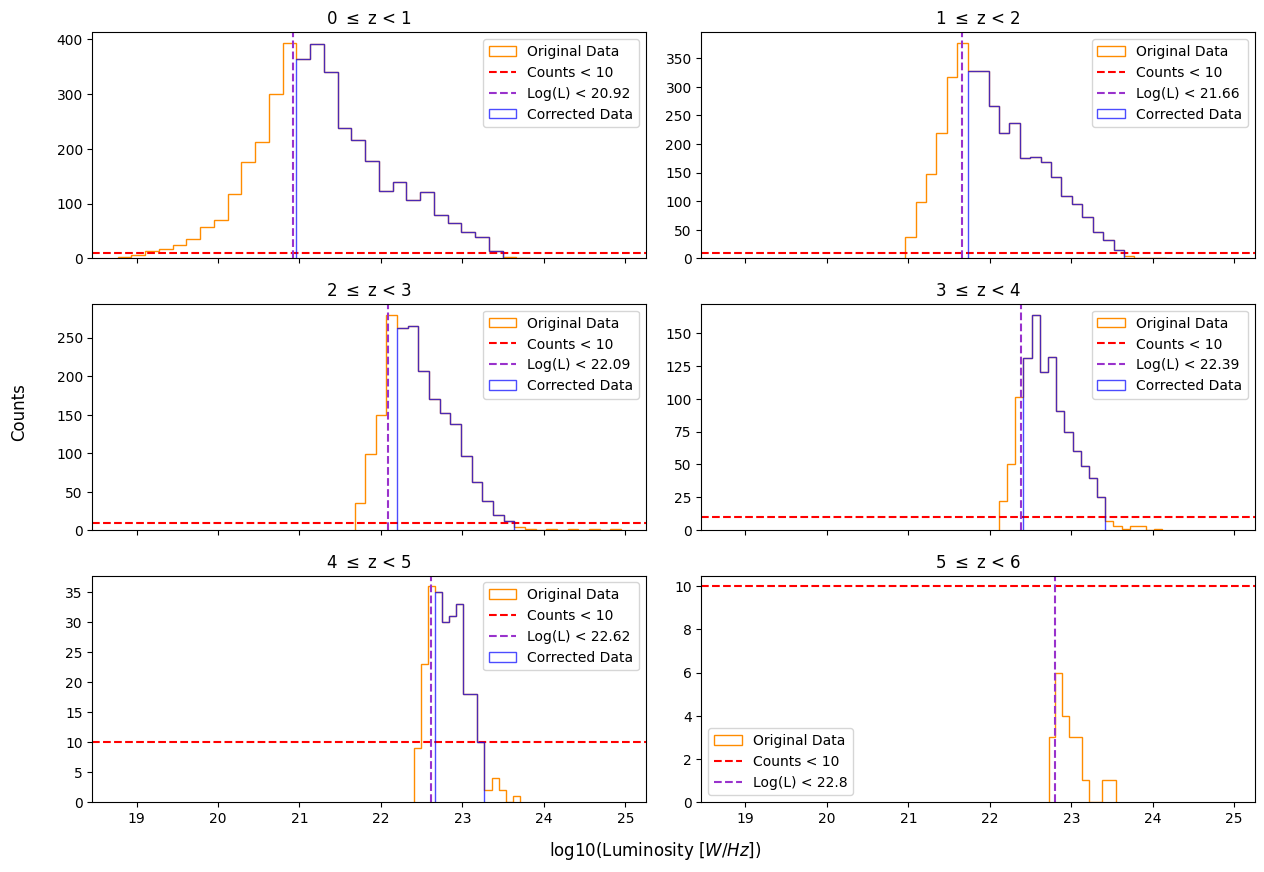

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (vol, lum), bins, ax in zip(redshift_bins, all_data, all_mag_bins, axes.flatten()):
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity)[(z >= z_start) & (z < z_end)], bins=bins, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(lum_lim(z_end)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(lum_lim(z_end)), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

### Luminosity Function

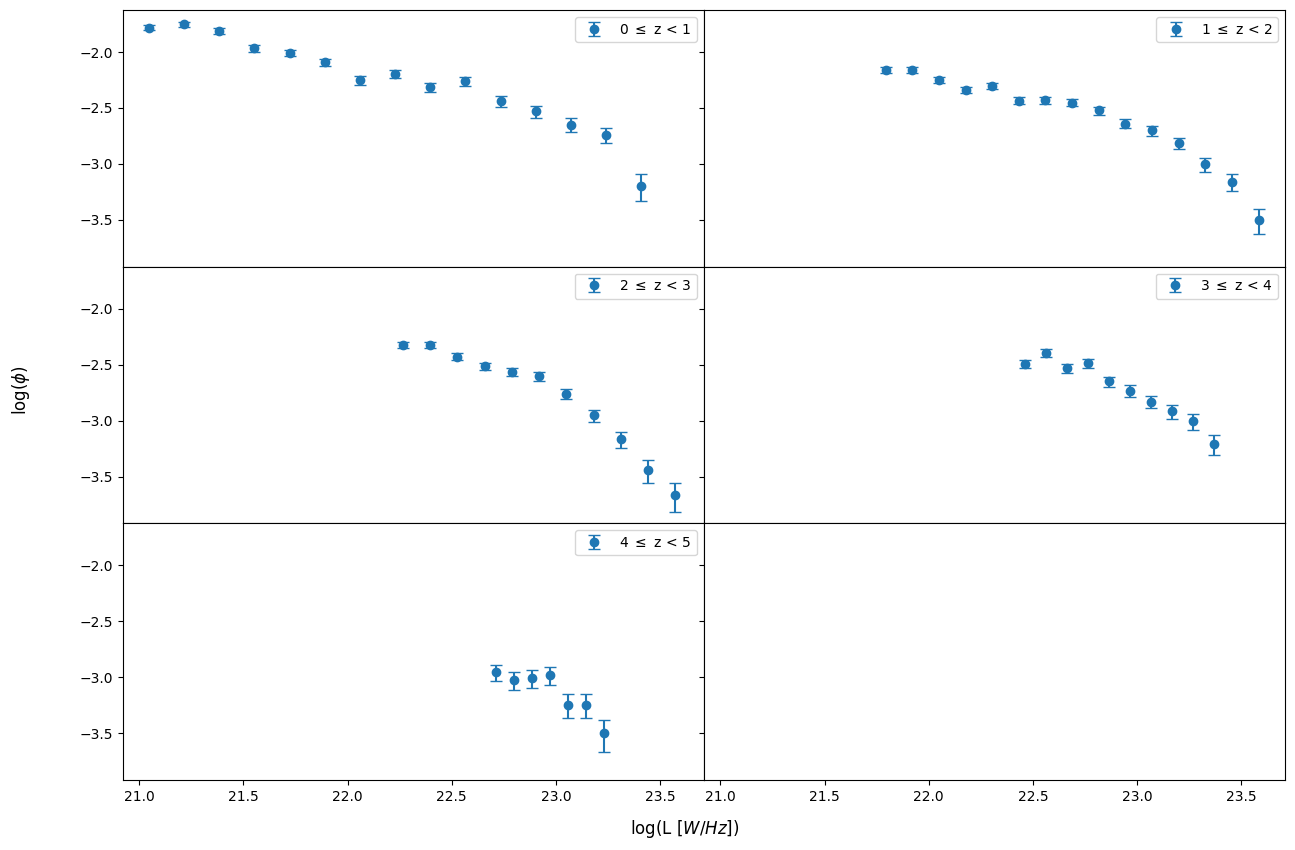

In [7]:
lum_centers, phi, phi_e = [], [], []

# Volume and magnitude are already binned by redshift
for (vol, mag), bin, in zip(all_data, bin_edges):
    
    # delta_log_l = np.diff(np.log10(np.abs(bin[::-1])))[0]
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (mag >= lum_start) & (mag < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend()

fig.supxlabel('log(L [$W/Hz$])', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

### Schechter Fit

C:\Users\danie\AppData\Local\Temp\ipykernel_9724\2977192395.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))


0 <= z < 1 Function fit:
M_star = 2.33e+01
phi_star = 3.93e-03
alpha = 1.79e+00


1 <= z < 2 Function fit:
M_star = 2.26e+01
phi_star = 9.85e-03
alpha = 1.19e+00


2 <= z < 3 Function fit:
M_star = 2.16e+01
phi_star = 1.41e-02
alpha = -2.87e-01


3 <= z < 4 Function fit:
M_star = 2.10e+01
phi_star = 1.22e-03
alpha = -2.65e+00


4 <= z < 5 Function fit:
M_star = 2.02e+01
phi_star = 2.12e-10
alpha = -1.00e+01




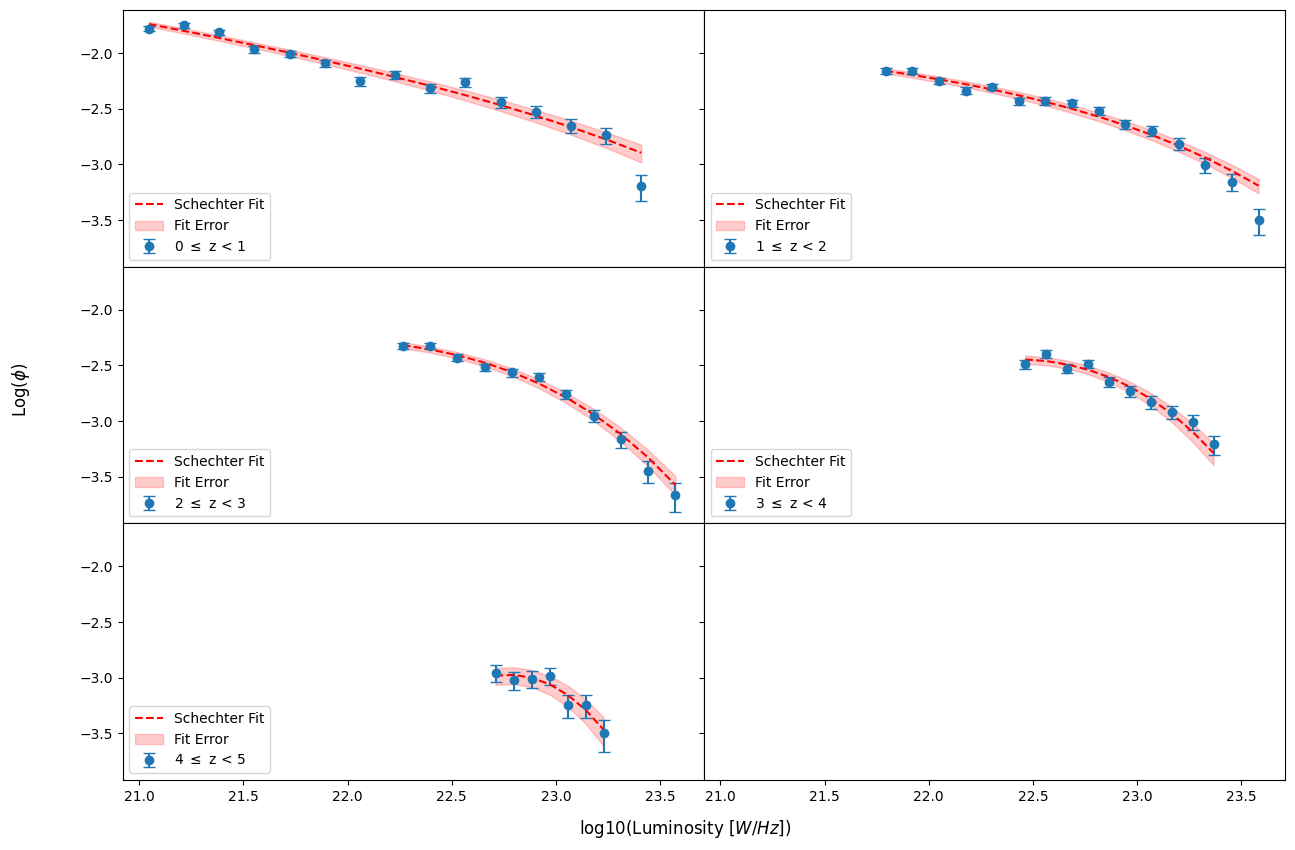

In [8]:
def schechter_magnitude(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_magnitude, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(schechter_magnitude, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(schechter_magnitude, lum, p-e, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(schechter_magnitude(lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(lum, 
        np.log10(schechter_magnitude(lum, *p_down)),
        np.log10(schechter_magnitude(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error') 
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

0 <= z < 1 Function fit:
M_star = 1.71e+01
phi_star = 4.27e-02
alpha = 6.07e-01
sigma = 7.49e-01


1 <= z < 2 Function fit:
M_star = 3.34e+01
phi_star = 7.37e-06
alpha = 1.65e+00
sigma = 2.98e-05




C:\Users\danie\AppData\Local\Temp\ipykernel_9724\2001038811.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M_star-M))))**2)


2 <= z < 3 Function fit:
M_star = 3.23e+01
phi_star = 1.13e-03
alpha = 1.19e+00
sigma = 5.70e-05


3 <= z < 4 Function fit:
M_star = 1.83e+01
phi_star = 8.50e-20
alpha = -1.96e+01
sigma = 1.86e-01


4 <= z < 5 Function fit:
M_star = 3.05e+01
phi_star = 1.89e+12
alpha = -3.63e+00
sigma = 1.69e-04




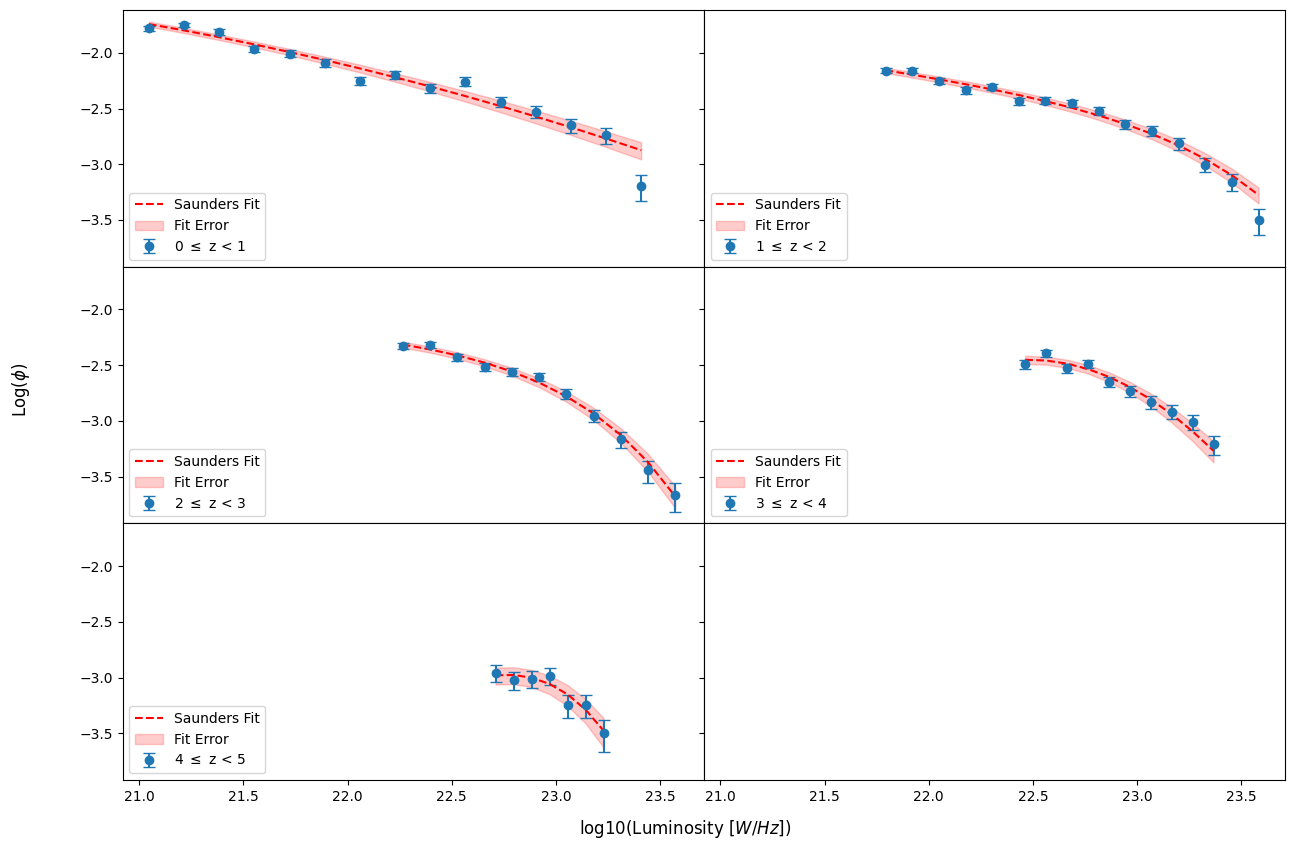

In [11]:
def saunders_magnitude(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M_star-M))))**2)

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0 = [lum[0], 0.001, -0.9, 0.1]
    try:
        params, _ = curve_fit(saunders_magnitude, lum, p, p0=p0, maxfev=100000)
        p_up, _ = curve_fit(saunders_magnitude, lum, p+e, p0=p0, maxfev=100000)
        p_down, _ = curve_fit(saunders_magnitude, lum, p-e, p0=p0, maxfev=100000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue       
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(saunders_magnitude(lum, *params)), color='red', label='Saunders Fit', linestyle='--')   
    ax.fill_between(lum, 
        np.log10(saunders_magnitude(lum, *p_down)), 
        np.log10(saunders_magnitude(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()